# $1^{st}$ exercises

## Notebook setup

#### Libraries

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import cauchy

#### Load and print config files

In [3]:
def LoadConf(path):
    d={}
    with open(path) as file:
        for line in file:
            (directive,key, val) = line.split()
            if(directive=="#define"): d[key] = int(val)
    return d

def PrintConf(d):
    for key, val in d.items(): print("{0:<19}{1}".format(key,val))

#### Colors, just for fun

In [4]:
bgp = "#191724" #background
ste = "#e0def4" #main elements
nde = "#eb6f92" #additional elemets
err = "#908caa" #error bar
er2 = "#6e6a86" #second error bar

## 01.1 - Testing the pseudo-random number generator

### Introductory notes
We have in `lib/Random` a pesudo-random number generator, which basic funtionality is to generate a number $r\in[0,1)$ with a uniform probability distribution. This is the main building block to extract number from other distributions, so it's important to be provided with a *good* random number generator when dealing with montecarlo algorithms. We want to test if our generator is such.

A first simple thing to do is to evaluate the mean value $\langle r \rangle$ and variance $\sigma^2$ of generated numbers. We would expect to find values compatible with
\begin{equation}
    \begin{split}
         & \langle r \rangle = \int_0^1 r dr = 1/2\\
         & \sigma^2          = \int_0^1 \Bigl(r-\frac{1}{2}\Bigr)^2 dr = \frac{1}{12}\\
     \end{split}
\end{equation}

Another thing we can try to evaluate is the probability that a generated number is drawn from a uniform distribution, in other words the $\chi^2$ test. DA CAPIRE

### Brief recap
**Goal:** We want to test the quality of the pseudo-random number generator in `lib/Random`, which basic function is to exctract a uniformly a number $r\in[0,1)$. To do so, we are going to evaluate the mean $\langle r \rangle$ and the variance $\sigma^2$ of the random numbers generated, and to implement a $\chi^2$ test.

**Expectations:**  <br>
- Mean: $\langle r\rangle=\int_0^1\mathrm{d}r\,r=0.5$; <br>
- Variance: $\sigma^2=\int_0^1\mathrm{d}r\,(r-0.5)^2=0.08\overline{3}$<br>
- $\chi^2$ test: 
 
**Methodological notes:** We use data blocking to evaluate statistical uncertainties for $\langle r\rangle,\,\sigma^2$.

###  Mean and Variance
For mean and variance evaluations we used `N_BLOCKS` blocks with `STEPS_PER_BLOCK` steps each - 
where:

In [5]:
conf=LoadConf("in/011-ave_var-conf.inl")
PrintConf(conf)

N_BLOCKS           100
STEPS_PER_BLOCK    1000


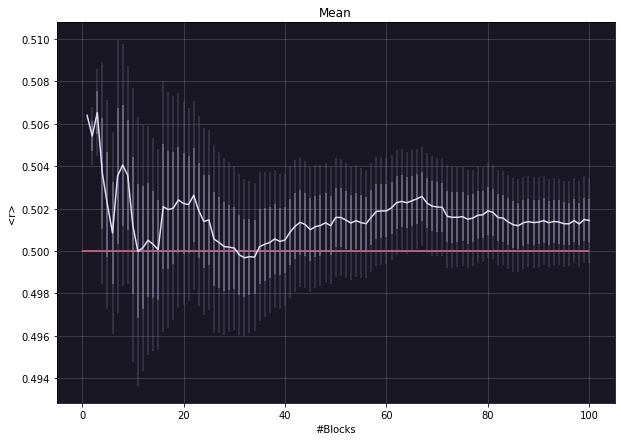

In [6]:
data = np.genfromtxt("out/011-mean_value.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,3]
e=data[:,4]

fig=plt.figure(figsize=(10, 7))
plt.axes().set_facecolor(bgp)

plt.hlines(0.5, 0,conf["N_BLOCKS"],color=nde)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4)
plt.errorbar(x,y,color=ste)
plt.xlabel('#Blocks')
plt.ylabel('<r>')
plt.title("Mean")
plt.grid(alpha=0.3)
plt.show()

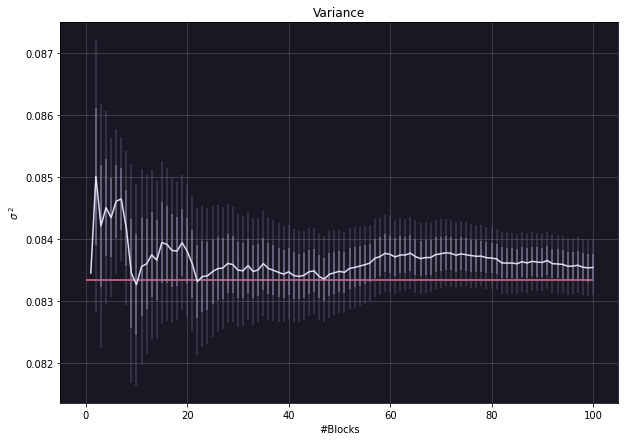

In [7]:
data = np.genfromtxt("out/011-variance.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,3]
e=data[:,4]

fig=plt.figure(figsize=(10, 7))
plt.axes().set_facecolor(bgp)

plt.hlines(1/12, 0,conf["N_BLOCKS"],color=nde)

plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4)
plt.errorbar(x,y,color=ste)
plt.xlabel('#Blocks')
plt.ylabel('$\sigma\,^2$')
plt.title("Variance")
plt.grid(alpha=0.3)
plt.show()

We have plotted the progressive averages of the quantity of interest in function of the number of blocks. 
The horizontal line represent the expected values; the error bars are placed at $\sigma$ and at $2\sigma$. 
We can see that the values obtained are compatible with the expected average of $0.5$ and with the expected variance of $1/12$.

###  $\chi^2$ test

We run `N_TESTS` $\chi^2$ tests with `THROWS` throws each. The $[0,1)$ interval has been divided in `N_INTERVALS` subintervals - where:

In [8]:
conf=LoadConf("in/011-chi2-conf.inl")
PrintConf(conf)

N_INTERVALS        100
THROWS             10000
N_TESTS            100


The expected value to be tested is `THROWS/N_INTERVALS`=100

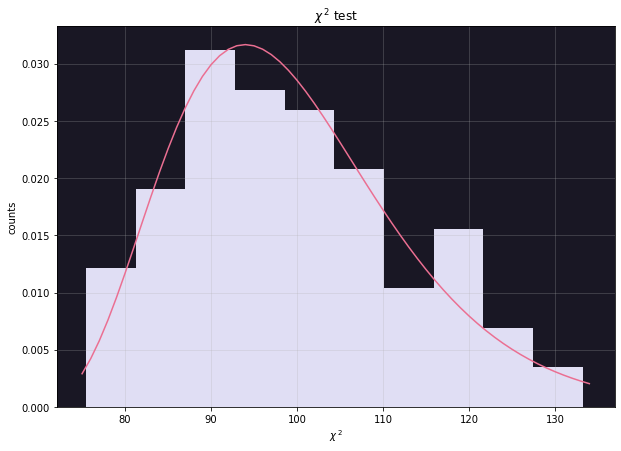

In [9]:
data = np.genfromtxt("out/011-chi2.dat")

fig=plt.figure(figsize=(10, 7))
plt.axes().set_facecolor(bgp)

plt.hist(data,color=ste,density=True)

params = chi2.fit(data) 
x = np.arange(75,135)
y = chi2.pdf(x, *params)
plt.plot(x, y, color=nde)

plt.xlabel('$\chi\,^2$')
plt.ylabel('counts')
plt.title("$\chi\,^2$ test")
plt.grid(alpha=0.3)
plt.show()

The plot is a normalized hystogram representing the distribution of the $\chi^2$ resulting from our tests. Though the number of subintervals and test is not sufficent for a precise fit, we can see that our hystogram is well fitted by an actual $\chi^2$ pdf peaked in a neighbourhood of $100$. This means that it's rather unlikely for our numbers not to be generated from a uniform distribution.

## 01.2 - Testing the central limit theorem

### Introductory notes
As said, with a uniform random number generator we can sample other pdf. An efficent method is the Inversion of the Cumulative Method, which is applicable under quite strong hypothesis:
- the pdf $p$ has to be integrable
- its cumulative $F(x)=\int_{-\infty}^x p(s) ds$ has to be invertible
- we must have an analytic expression for its inverse

If these three requirements are met we have that if $y$ is drawn from a uniform distribution in $[0,1)$ then 
$x=F^{-1}(y)$ is drawn from $p$ (In fact, just the first two hypothesis are *foundamental*. Nevertheless if the third is not fulfilled we won't have an exact sampling when we implement the method). Luckly this is the case for teh exponential distribution and the Cauchy-Lorenz distribution, where we have:
\begin{equation}
    \begin{split}
        p_{\lambda}:[0,+\infty)\to [0,+\infty):x\mapsto \lambda e^{-\lambda x} 
            &\longleftrightarrow x=-\frac{\ln(1-y)}{\lambda}\\
        p_{\mu,\Gamma}:\mathbb{R}\to [0,+\infty):x\mapsto \frac{1}{\pi}\frac{\Gamma}{(x-\mu)^2-\Gamma^2}
            &\longleftrightarrow x=\Gamma\tan\Bigl[\pi\Bigl(y-\frac{1}{2}\Bigr)\Bigr]+\mu\\
    \end{split}
\end{equation}

The procedure is a little different for the Gaussian distribution, which cumulative is the error function (not known analitically). We can still use the inversion of the cumulative methon considerig the product of two Gaussians and working in polar coordinates (box-muller alghorithm).

DA RIVEDERE !!!!!
Equipped with these new tools we can, for example, test the central limit theorem (CLT) which states that, if
- a set $\{x_i\}$ of indipendent and equally distributed random variables
- has mean $\mu$
- and **finite** variance $\sigma^2$

then for the quantity $A_N=\sum_i^N x_i$ in the limit $N\to\infty$ we have:
- $\langle A_N \rangle \to \mu$
- $\sigma^2_{A_N}\to \sigma^2/N$
- the pdf of $A_N$, $p_{A_N}\to N(\mu,\sigma_{A_N})$ with $N$ the Gaussian 

This is the case for the uniform and the exponential distribution! On the other hand, the Cauchy-Lorenz distribution has infinite variance. A generalization of the theorem states that if a pdf convolution fulfils some properties, that pdf is a limit pdf. This is the case for the lorenzian, which is its own limit function.

According to what we have stated, we can test the CLT in the following way. We make an histogram of a large number of realizations of $A_N=\sum_i^N x_i/N$ and: for small $N$ we expect it to have a shape similar to that of the distribution from which $x_i$ are drawn; for large $N$ we expect it to converge to the limit distribution - a Gaussian if $x_i$ are generated using the uniform and the exponential distribution, a lorenzian if they are generated from a lorenzian.

## Brief recap
**Goal:** Extending the pseudo-random number generator introducing sampling from the exponential and the Cauchy-Lorentz distribution (using the method of the inverse cumulative distribution); Testing the central limit theorem (and it's generalized version) throwing a:
- Uniform dice
- Exponential dice ($\lambda=1$)
- Cauchy-Lorentz dice ($\mu=0$, $\Gamma=1$)

and making histograms of a large number of realizations of $A_N$.

**Expectations:** We expect that for large $N$ the histograms of obtained from the uniform and the exponential dices will be well fitted by a gaussian, while the lorentzian dice (having the distribution infinite variance) will be well fitted by a lorentzian. 

## Results
The histograms are made using `T` realizations of $A_N$ - where:

In [10]:
conf=LoadConf("in/012-conf.inl")
PrintConf(conf)

T                  10000


#### Uniform dice
To obtain a clear view of the convergence of the averages hystogram for increasing $N$ we divided $[1,6)$ into 100 subintervals instead of 6 subintervals of width 1. Thus, we are not properly simulating a dice. This is justified by the fact that the term "dice" is forced to be intended in somehow a broader meaning for the exponential and the lorentzian dices, since their values is taken in an infinite interval.

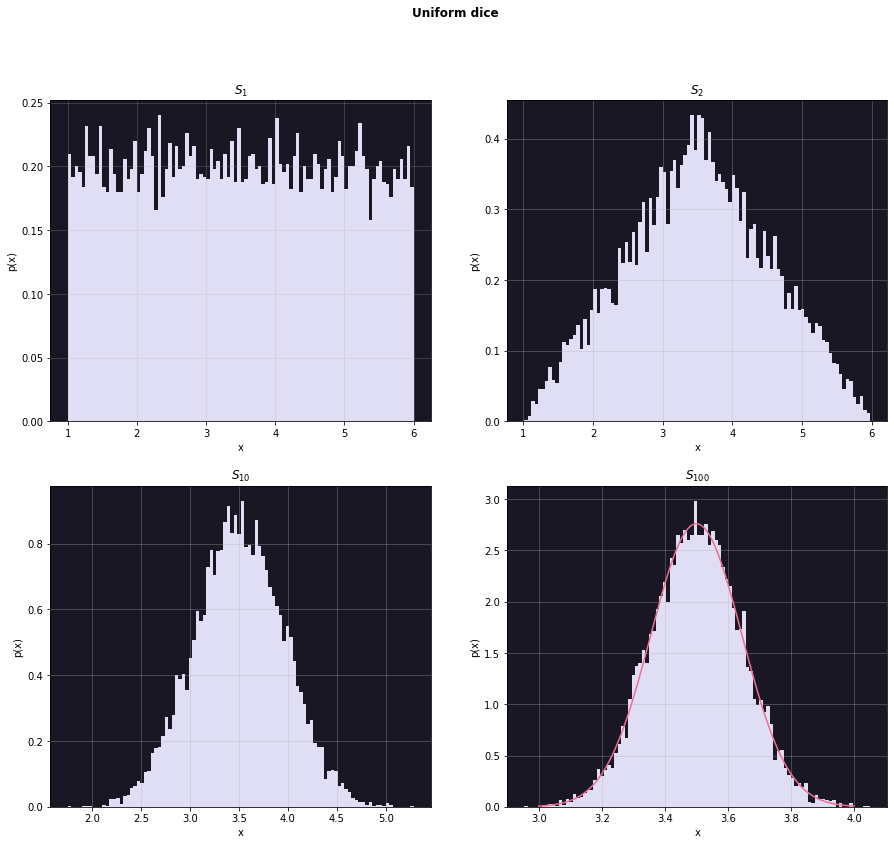

Gaussian with parameters:
μ=3.5000900500000003
σ=0.14455687602648828


In [11]:
xs = np.genfromtxt("out/012-unif.csv", delimiter=",", skip_header=1)

fig=plt.figure(figsize=(15, 13))
plt.suptitle('Uniform dice', weight='bold')

#N=1
plt.subplot(221)
fig.axes[0].set_facecolor(bgp)
plt.hist(xs[:,0],100, density=True, color=ste)
plt.title('$S_1$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.3) 


#N=2
plt.subplot(222)
fig.axes[1].set_facecolor(bgp)
plt.hist(xs[:,1],100, density=True, color=ste)
plt.title('$S_2$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.4) 

#N=10
plt.subplot(223)
fig.axes[2].set_facecolor(bgp)
plt.hist(xs[:,2],100, density=True, color=ste)
plt.title('$S_{10}$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.4) 

#N=100
plt.subplot(224)
fig.axes[3].set_facecolor(bgp)
plt.hist(xs[:,3],100, density=True, color=ste)

parameter = norm.fit(xs[:,3]) 
x = np.linspace(3, 4, 100)
y = norm.pdf(x, *parameter)
plt.plot(x, y, color=nde)

plt.title('$S_{100}$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.4) 


plt.show()
print("Gaussian with parameters:")
print("\u03BC="+str(parameter[0]))
print("\u03C3="+str(parameter[1]))

#### Exponential dice

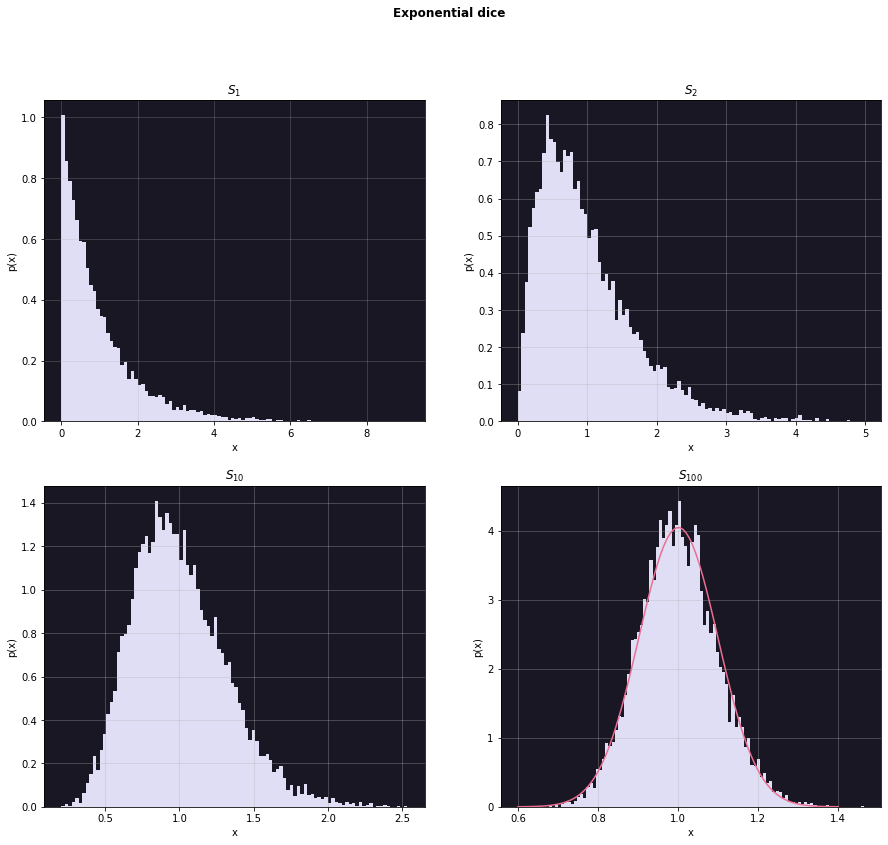

Gaussian with parameters:
μ=1.0005304437
σ=0.09862300935707058


In [12]:
xs = np.genfromtxt("out/012-exp.csv", delimiter=",", skip_header=1)

fig=plt.figure(figsize=(15, 13))
plt.suptitle('Exponential dice', weight='bold')

#N=1
plt.subplot(221)
fig.axes[0].set_facecolor(bgp)
plt.hist(xs[:,0],100, density=True, color=ste)
plt.title('$S_1$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.3) 


#N=2
plt.subplot(222)
fig.axes[1].set_facecolor(bgp)
plt.hist(xs[:,1],100, density=True, color=ste)
plt.title('$S_2$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.4) 

#N=10
plt.subplot(223)
fig.axes[2].set_facecolor(bgp)
plt.hist(xs[:,2],100, density=True, color=ste)
plt.title('$S_{10}$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.4) 

#N=100
plt.subplot(224)
fig.axes[3].set_facecolor(bgp)
plt.hist(xs[:,3],100, density=True, color=ste)

parameter = norm.fit(xs[:,3]) 
x = np.linspace(0.6, 1.4, 100)
y = norm.pdf(x, *parameter)
plt.plot(x, y, color=nde)

plt.title('$S_{100}$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.4) 

plt.show()

print("Gaussian with parameters:")
print("\u03BC="+str(parameter[0]))
print("\u03C3="+str(parameter[1]))

#### Lorentzian dice

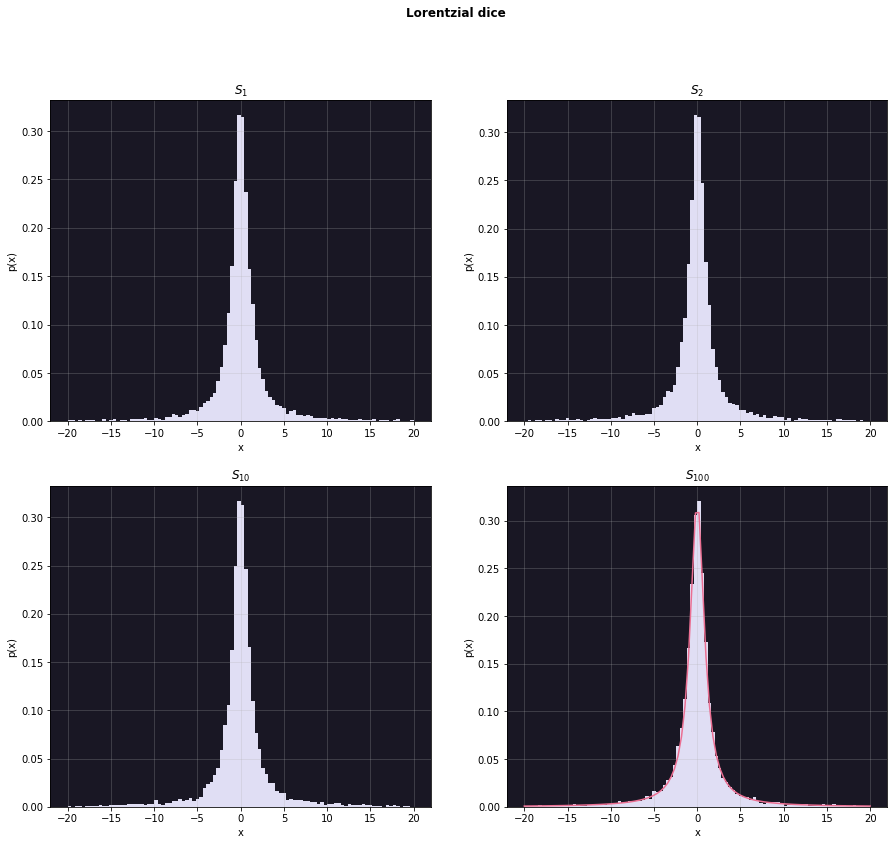

Lorenzian with parameters:
μ=0.002016215928899528
σ=0.9916838382842227


In [13]:
xs = np.genfromtxt("out/012-cauchy.csv", delimiter=",", skip_header=1)
edge=20

fig=plt.figure(figsize=(15, 13))
plt.suptitle('Lorentzial dice', weight='bold')

#N=1
plt.subplot(221)
fig.axes[0].set_facecolor(bgp)
plt.hist(xs[:,0], 100, range=(-edge,edge), density=True, color=ste)
plt.title('$S_1$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.3) 

#N=2
plt.subplot(222)
fig.axes[1].set_facecolor(bgp)
plt.hist(xs[:,1],100, range=(-edge,edge), density=True, color=ste)
plt.title('$S_2$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.3) 

#N=10
plt.subplot(223)
fig.axes[2].set_facecolor(bgp)
plt.hist(xs[:,2], 100, range=(-edge,edge), density=True, color=ste)
plt.title('$S_{10}$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.3) 

#N=100
plt.subplot(224)
fig.axes[3].set_facecolor(bgp)
plt.hist(xs[:,3], 100, range=(-edge,edge), density=True, color=ste)

parameter = cauchy.fit(xs[:,3]) 
x = np.linspace(-edge, edge, 100)
y = cauchy.pdf(x, *parameter)
plt.plot(x, y, color=nde)

plt.title('$S_{100}$')
plt.xlabel('x')
plt.ylabel('p(x)')
plt.grid(alpha=0.3) 


plt.show()
print("Lorenzian with parameters:")
print("\u03BC="+str(parameter[0]))
print("\u03C3="+str(parameter[1]))#é gamma davvero??

All histograms confirm our expectation.

## 01.3 - Buffon's experiment
### Introductory notes
Buffon's experiment is the name of a procedure to evaluate $\pi$ using a stochastic method. If we take a flat surface ruled with parallel lines at distance $d$, the probability that a needle of lenght $l<d$ intersects one of those lines is
\begin{equation}
    P=\frac{d\pi}{2l}
\end{equation}
Inverting this formula we can evaluate $\pi$. all we have to do is to throw a bounch of needles onto the flat surface and count how many needles intersect a line. Then can get an estimate of $P$ by dividing this number for the total number of needles. The more the throws, the better the approximation.

To simulate the experiment we firstly make some observation. We clearly see some symmetries: the problem is equivalent to that of "throwing" a segment of random lenght (the projection of the needle in the direction orthogonal to the lines) onto a 1d lattice of equally spaced points and the fact that we are only considering the projection means that the meaningful interval for the angle is that of width $\pi/2$; even more, the traslational symmetry allow us to focus on a single "cell" of the lattice and in fact, since we don't need to know which part of the needle intersects the line, we can focus only on half-a-cell. Then we have to notice that a direct sample of the angle needed for the projection would require to know the value of $\pi$. One would be tempted to try to generate the projection randomly and not just the angle, but to implement the inversion of the cumulative we still have to know $\pi$. In order to avoid that we can sample a "directional vector" in the first quadrant of the plane instead of the angle, by generating its coordinate $(x,y)$ in the square $[0,1)\times[0,1)$. Clealrly the more we get near the diagonal of the square the more vectors become available: to generate the vector uniformly we have to impose that $(x,y)$ lies in the circumference of radious 1. 

## Brief recap
**Goal:** Implement the Buffon's experiment to get an estimation for the value of $\pi$.

**Expectations:**  Well, $\pi$!
 
**Methodological notes:** 
We use datablocking to evaluate statistical uncertainties.

## Results
We used a grid of lines at distance `GRID_SPACE` and needles of lenght `NEEDLE_LENGHT` - where:

In [15]:
conf=LoadConf("in/013-conf-experiment.inl")
PrintConf(conf)

NEEDLE_LENGHT      1
GRID_SPACE         2


For data blocking we used `N_BLOCKS` blocks with `STEPS_PER_BLOCK` steps each - 
where:

In [16]:
conf=LoadConf("in/013-conf-datablocking.inl")
PrintConf(conf)

N_BLOCKS           100
STEPS_PER_BLOCK    10000


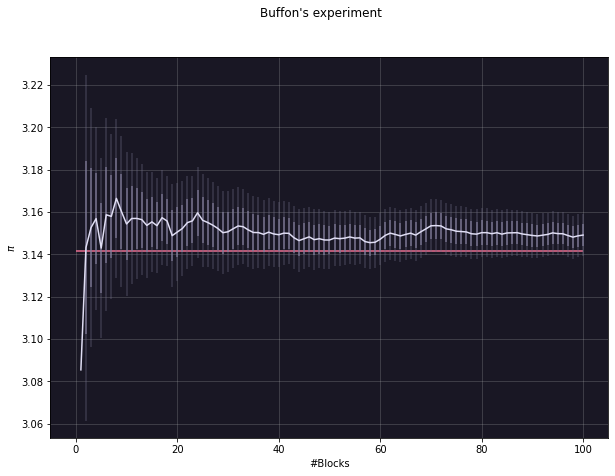

In [17]:
data = np.genfromtxt("out/013-pi_progressive_estimate_circle.csv", delimiter=",", skip_header=1)
x=data[:,0]
y=data[:,3]
e=data[:,4]

fig=plt.figure(figsize=(10, 7))
plt.axes().set_facecolor(bgp)
plt.suptitle("Buffon's experiment")

plt.hlines(3.1415926, 0, conf["N_BLOCKS"],color=nde)
plt.vlines(x,y-e,y+e,color=err,alpha=0.8)
plt.vlines(x,y-2*e,y+2*e,color=er2,alpha=0.4)
plt.errorbar(x,y,color=ste)
plt.xlabel('#Blocks')
plt.ylabel('$\pi$')
plt.grid(alpha=0.3)

plt.show()

We have plotted the progressive averages for the estimated value of $\pi$ in function of the number of blocks and the true value of $\pi$. The error bars corresponds to $\sigma$ and $2\sigma$. As we can see, our estimation in compatible with the true value of  $\pi$.